# FB Prophet Model - Unemployment Rate (%)

Training (1997-2020), Training (2021-2023)

# Packages & Data Loading

## Packages

In [1]:
# Import packages
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna
from io import StringIO
import requests
import matplotlib.pyplot as plt

from prophet.plot import plot_plotly, plot_components_plotly
import plotly.graph_objects as go

## Data Loading

In [2]:
# Load data from Google Drive
file_id = '117pk3NKZPfYmHQyP452HeMV7_8Jq6_W0'

# Create the download URL
download_url = f'https://drive.google.com/uc?export=download&id={file_id}'

# Use requests to get file content
response = requests.get(download_url)
response.raise_for_status()  # Ensure no error occurred

# Load the CSV directly into a DataFrame
csv_data = StringIO(response.text)
df = pd.read_csv(csv_data)

In [3]:
# Prepare and process data
df_selected = df[['ref_date', 'value_unemployment']].copy()
df_grouped = df_selected.groupby('ref_date').agg(
    median_unemployment=('value_unemployment', 'median')
).reset_index()
df_grouped['ref_date'] = pd.to_datetime(df_grouped['ref_date'])
df_grouped.set_index('ref_date', inplace=True)

# FB Prophet Model

## Assign Training & Testing Sets

In [4]:
# Split into training and testing sets
train_data = df_grouped['1997-01-01':'2020-12-01']
test_data = df_grouped['2021-01-01':'2023-12-01']
train_data = train_data.reset_index().rename(columns={'ref_date': 'ds', 'median_unemployment': 'y'})
test_data = test_data.reset_index().rename(columns={'ref_date': 'ds', 'median_unemployment': 'y'})


# Cross Validation

In [5]:
# Optuna optimization
def optimize_prophet(trial):
    # Define hyperparameters
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True)
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.01, 10.0, log=True)
    holidays_prior_scale = trial.suggest_float('holidays_prior_scale', 0.01, 10.0, log=True)
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])

    # Initialize model with suggested parameters
    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        seasonality_mode=seasonality_mode
    )
    model.fit(train_data)

    # Perform cross-validation
    df_cv = cross_validation(model, initial='7300 days', period='365 days', horizon='365 days')
    df_p = performance_metrics(df_cv)
    return df_p['rmse'].mean()

# Model Parameters

In [6]:
# Optimize using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(optimize_prophet, n_trials=50)

# Best parameters
best_params = study.best_params
print("\n\nBest Parameters:", best_params)

# Train model with optimized parameters
optimized_model = Prophet(**best_params)
optimized_model.fit(train_data)

[I 2024-11-30 20:00:08,163] A new study created in memory with name: no-name-b052e971-575b-49f9-93a2-05eaa1d2d7ce
20:00:08 - cmdstanpy - INFO - Chain [1] start processing
20:00:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:08 - cmdstanpy - INFO - Chain [1] start processing
20:00:08 - cmdstanpy - INFO - Chain [1] done processing
20:00:09 - cmdstanpy - INFO - Chain [1] start processing
20:00:09 - cmdstanpy - INFO - Chain [1] done processing
20:00:09 - cmdstanpy - INFO - Chain [1] start processing
20:00:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:09,408] Trial 0 finished with value: 2.9614944616791288 and parameters: {'changepoint_prior_scale': 0.24418552717096068, 'seasonality_prior_scale': 1.1409988970564486, 'holidays_prior_scale': 0.6640928971798221, 'seasonality_mode': 'multiplicative'}. Best is trial 0 with value: 2.9614944616791288.
20:00:09 - cmdstanpy - INFO - Chain [1] start processing
20:00:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:09 - cmdstanpy - INFO - Chain [1] start processing
20:00:09 - cmdstanpy - INFO - Chain [1] done processing
20:00:09 - cmdstanpy - INFO - Chain [1] start processing
20:00:10 - cmdstanpy - INFO - Chain [1] done processing
20:00:10 - cmdstanpy - INFO - Chain [1] start processing
20:00:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:10,295] Trial 1 finished with value: 2.8644648182956187 and parameters: {'changepoint_prior_scale': 0.07582978096590656, 'seasonality_prior_scale': 2.1734853107505865, 'holidays_prior_scale': 2.182395626443918, 'seasonality_mode': 'additive'}. Best is trial 1 with value: 2.8644648182956187.
20:00:10 - cmdstanpy - INFO - Chain [1] start processing
20:00:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:10 - cmdstanpy - INFO - Chain [1] start processing
20:00:10 - cmdstanpy - INFO - Chain [1] done processing
20:00:10 - cmdstanpy - INFO - Chain [1] start processing
20:00:10 - cmdstanpy - INFO - Chain [1] done processing
20:00:11 - cmdstanpy - INFO - Chain [1] start processing
20:00:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:11,154] Trial 2 finished with value: 2.887078471840049 and parameters: {'changepoint_prior_scale': 0.003831047122792934, 'seasonality_prior_scale': 0.02476758317729253, 'holidays_prior_scale': 5.450187461334194, 'seasonality_mode': 'multiplicative'}. Best is trial 1 with value: 2.8644648182956187.
20:00:11 - cmdstanpy - INFO - Chain [1] start processing
20:00:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:11 - cmdstanpy - INFO - Chain [1] start processing
20:00:11 - cmdstanpy - INFO - Chain [1] done processing
20:00:11 - cmdstanpy - INFO - Chain [1] start processing
20:00:11 - cmdstanpy - INFO - Chain [1] done processing
20:00:11 - cmdstanpy - INFO - Chain [1] start processing
20:00:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:12,013] Trial 3 finished with value: 2.899045018426206 and parameters: {'changepoint_prior_scale': 0.004385847364821009, 'seasonality_prior_scale': 0.07443866947345391, 'holidays_prior_scale': 3.086280556323888, 'seasonality_mode': 'additive'}. Best is trial 1 with value: 2.8644648182956187.
20:00:12 - cmdstanpy - INFO - Chain [1] start processing
20:00:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:12 - cmdstanpy - INFO - Chain [1] start processing
20:00:12 - cmdstanpy - INFO - Chain [1] done processing
20:00:12 - cmdstanpy - INFO - Chain [1] start processing
20:00:12 - cmdstanpy - INFO - Chain [1] done processing
20:00:12 - cmdstanpy - INFO - Chain [1] start processing
20:00:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:12,943] Trial 4 finished with value: 2.9265462796584742 and parameters: {'changepoint_prior_scale': 0.20019824430199085, 'seasonality_prior_scale': 0.26319643869155024, 'holidays_prior_scale': 3.5393195619137656, 'seasonality_mode': 'additive'}. Best is trial 1 with value: 2.8644648182956187.
20:00:13 - cmdstanpy - INFO - Chain [1] start processing
20:00:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:13 - cmdstanpy - INFO - Chain [1] start processing
20:00:13 - cmdstanpy - INFO - Chain [1] done processing
20:00:13 - cmdstanpy - INFO - Chain [1] start processing
20:00:13 - cmdstanpy - INFO - Chain [1] done processing
20:00:13 - cmdstanpy - INFO - Chain [1] start processing
20:00:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:13,882] Trial 5 finished with value: 2.9918751280094655 and parameters: {'changepoint_prior_scale': 0.4042506695813918, 'seasonality_prior_scale': 0.2233184130616852, 'holidays_prior_scale': 3.6925880691160686, 'seasonality_mode': 'multiplicative'}. Best is trial 1 with value: 2.8644648182956187.
20:00:14 - cmdstanpy - INFO - Chain [1] start processing
20:00:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:14 - cmdstanpy - INFO - Chain [1] start processing
20:00:14 - cmdstanpy - INFO - Chain [1] done processing
20:00:14 - cmdstanpy - INFO - Chain [1] start processing
20:00:14 - cmdstanpy - INFO - Chain [1] done processing
20:00:14 - cmdstanpy - INFO - Chain [1] start processing
20:00:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:14,704] Trial 6 finished with value: 2.927345929265485 and parameters: {'changepoint_prior_scale': 0.0041234683222838376, 'seasonality_prior_scale': 6.594845478543022, 'holidays_prior_scale': 0.7746984752640077, 'seasonality_mode': 'multiplicative'}. Best is trial 1 with value: 2.8644648182956187.
20:00:14 - cmdstanpy - INFO - Chain [1] start processing
20:00:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:15 - cmdstanpy - INFO - Chain [1] start processing
20:00:15 - cmdstanpy - INFO - Chain [1] done processing
20:00:15 - cmdstanpy - INFO - Chain [1] start processing
20:00:15 - cmdstanpy - INFO - Chain [1] done processing
20:00:15 - cmdstanpy - INFO - Chain [1] start processing
20:00:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:15,552] Trial 7 finished with value: 2.82422606068949 and parameters: {'changepoint_prior_scale': 0.0037804916930191525, 'seasonality_prior_scale': 0.7256900873460941, 'holidays_prior_scale': 0.11926218136273253, 'seasonality_mode': 'additive'}. Best is trial 7 with value: 2.82422606068949.
20:00:15 - cmdstanpy - INFO - Chain [1] start processing
20:00:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:15 - cmdstanpy - INFO - Chain [1] start processing
20:00:15 - cmdstanpy - INFO - Chain [1] done processing
20:00:16 - cmdstanpy - INFO - Chain [1] start processing
20:00:16 - cmdstanpy - INFO - Chain [1] done processing
20:00:16 - cmdstanpy - INFO - Chain [1] start processing
20:00:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:16,401] Trial 8 finished with value: 2.874240113203599 and parameters: {'changepoint_prior_scale': 0.011484827531743078, 'seasonality_prior_scale': 0.10595425080906815, 'holidays_prior_scale': 1.3541348915829878, 'seasonality_mode': 'additive'}. Best is trial 7 with value: 2.82422606068949.
20:00:16 - cmdstanpy - INFO - Chain [1] start processing
20:00:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:16 - cmdstanpy - INFO - Chain [1] start processing
20:00:16 - cmdstanpy - INFO - Chain [1] done processing
20:00:17 - cmdstanpy - INFO - Chain [1] start processing
20:00:17 - cmdstanpy - INFO - Chain [1] done processing
20:00:17 - cmdstanpy - INFO - Chain [1] start processing
20:00:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:17,349] Trial 9 finished with value: 2.848050436632355 and parameters: {'changepoint_prior_scale': 0.05007179245625522, 'seasonality_prior_scale': 2.5587872893116725, 'holidays_prior_scale': 0.03753483602267697, 'seasonality_mode': 'multiplicative'}. Best is trial 7 with value: 2.82422606068949.
20:00:17 - cmdstanpy - INFO - Chain [1] start processing
20:00:17 - cmdstanpy - INFO - Chain [1] done processing
20:00:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:00:17 - cmdstanpy - INFO - Chain [1] start processing
20:00:17 - cmdstan

  0%|          | 0/3 [00:00<?, ?it/s]

20:00:18 - cmdstanpy - INFO - Chain [1] start processing
20:00:18 - cmdstanpy - INFO - Chain [1] done processing
20:00:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:00:18 - cmdstanpy - INFO - Chain [1] start processing
20:00:18 - cmdstanpy - INFO - Chain [1] done processing
20:00:18 - cmdstanpy - INFO - Chain [1] start processing
20:00:18 - cmdstanpy - INFO - Chain [1] done processing
20:00:18 - cmdstanpy - INFO - Chain [1] start processing
20:00:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:19,004] Trial 10 finished with value: 3.35098879834818 and parameters: {'changepoint_prior_scale': 0.0010069054726492004, 'seasonality_prior_scale': 0.8902404316293274, 'holidays_prior_scale': 0.0952797821020568, 'seasonality_mode': 'additive'}. Best is trial 7 with value: 2.82422606068949.
20:00:19 - cmdstanpy - INFO - Chain [1] start processing
20:00:19 - cmdstanpy - 

  0%|          | 0/3 [00:00<?, ?it/s]

20:00:19 - cmdstanpy - INFO - Chain [1] start processing
20:00:19 - cmdstanpy - INFO - Chain [1] done processing
20:00:19 - cmdstanpy - INFO - Chain [1] start processing
20:00:19 - cmdstanpy - INFO - Chain [1] done processing
20:00:19 - cmdstanpy - INFO - Chain [1] start processing
20:00:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:19,881] Trial 11 finished with value: 2.864929374431623 and parameters: {'changepoint_prior_scale': 0.03704277317775759, 'seasonality_prior_scale': 8.96563549034579, 'holidays_prior_scale': 0.01580011057096871, 'seasonality_mode': 'multiplicative'}. Best is trial 7 with value: 2.82422606068949.
20:00:20 - cmdstanpy - INFO - Chain [1] start processing
20:00:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:20 - cmdstanpy - INFO - Chain [1] start processing
20:00:20 - cmdstanpy - INFO - Chain [1] done processing
20:00:20 - cmdstanpy - INFO - Chain [1] start processing
20:00:20 - cmdstanpy - INFO - Chain [1] done processing
20:00:20 - cmdstanpy - INFO - Chain [1] start processing
20:00:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:20,749] Trial 12 finished with value: 2.8733414449927692 and parameters: {'changepoint_prior_scale': 0.017756705092810566, 'seasonality_prior_scale': 2.1532794086419447, 'holidays_prior_scale': 0.09574384329878566, 'seasonality_mode': 'additive'}. Best is trial 7 with value: 2.82422606068949.
20:00:20 - cmdstanpy - INFO - Chain [1] start processing
20:00:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:21 - cmdstanpy - INFO - Chain [1] start processing
20:00:21 - cmdstanpy - INFO - Chain [1] done processing
20:00:21 - cmdstanpy - INFO - Chain [1] start processing
20:00:21 - cmdstanpy - INFO - Chain [1] done processing
20:00:21 - cmdstanpy - INFO - Chain [1] start processing
20:00:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:21,611] Trial 13 finished with value: 2.853812341886089 and parameters: {'changepoint_prior_scale': 0.0712242933025115, 'seasonality_prior_scale': 0.6752039325765283, 'holidays_prior_scale': 0.020681978843558282, 'seasonality_mode': 'multiplicative'}. Best is trial 7 with value: 2.82422606068949.
20:00:21 - cmdstanpy - INFO - Chain [1] start processing
20:00:21 - cmdstanpy - INFO - Chain [1] done processing
20:00:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:00:21 - cmdstanpy - INFO - Chain [1] start processing
20:00:22 - cmdsta

  0%|          | 0/3 [00:00<?, ?it/s]

20:00:22 - cmdstanpy - INFO - Chain [1] start processing
20:00:22 - cmdstanpy - INFO - Chain [1] done processing
20:00:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:00:22 - cmdstanpy - INFO - Chain [1] start processing
20:00:22 - cmdstanpy - INFO - Chain [1] done processing
20:00:22 - cmdstanpy - INFO - Chain [1] start processing
20:00:23 - cmdstanpy - INFO - Chain [1] done processing
20:00:23 - cmdstanpy - INFO - Chain [1] start processing
20:00:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:23,294] Trial 14 finished with value: 3.047752288730362 and parameters: {'changepoint_prior_scale': 0.0011916838056152087, 'seasonality_prior_scale': 3.4186559999214317, 'holidays_prior_scale': 0.10855638376873027, 'seasonality_mode': 'additive'}. Best is trial 7 with value: 2.82422606068949.
20:00:23 - cmdstanpy - INFO - Chain [1] start processing
20:00:23 - cmdstanpy 

  0%|          | 0/3 [00:00<?, ?it/s]

20:00:23 - cmdstanpy - INFO - Chain [1] start processing
20:00:23 - cmdstanpy - INFO - Chain [1] done processing
20:00:23 - cmdstanpy - INFO - Chain [1] start processing
20:00:23 - cmdstanpy - INFO - Chain [1] done processing
20:00:24 - cmdstanpy - INFO - Chain [1] start processing
20:00:24 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:24,136] Trial 15 finished with value: 2.855684628322448 and parameters: {'changepoint_prior_scale': 0.008754761782304632, 'seasonality_prior_scale': 0.4747022815703726, 'holidays_prior_scale': 0.03944055616268218, 'seasonality_mode': 'multiplicative'}. Best is trial 7 with value: 2.82422606068949.
20:00:24 - cmdstanpy - INFO - Chain [1] start processing
20:00:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:24 - cmdstanpy - INFO - Chain [1] start processing
20:00:24 - cmdstanpy - INFO - Chain [1] done processing
20:00:24 - cmdstanpy - INFO - Chain [1] start processing
20:00:24 - cmdstanpy - INFO - Chain [1] done processing
20:00:24 - cmdstanpy - INFO - Chain [1] start processing
20:00:24 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:25,000] Trial 16 finished with value: 2.8473152230203547 and parameters: {'changepoint_prior_scale': 0.04249938298016147, 'seasonality_prior_scale': 1.5746306700869532, 'holidays_prior_scale': 0.24064457263902264, 'seasonality_mode': 'multiplicative'}. Best is trial 7 with value: 2.82422606068949.
20:00:25 - cmdstanpy - INFO - Chain [1] start processing
20:00:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:25 - cmdstanpy - INFO - Chain [1] start processing
20:00:25 - cmdstanpy - INFO - Chain [1] done processing
20:00:25 - cmdstanpy - INFO - Chain [1] start processing
20:00:25 - cmdstanpy - INFO - Chain [1] done processing
20:00:25 - cmdstanpy - INFO - Chain [1] start processing
20:00:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:25,923] Trial 17 finished with value: 2.8423754094098195 and parameters: {'changepoint_prior_scale': 0.029122270445457833, 'seasonality_prior_scale': 0.0107931636549982, 'holidays_prior_scale': 0.27604950120244, 'seasonality_mode': 'additive'}. Best is trial 7 with value: 2.82422606068949.
20:00:26 - cmdstanpy - INFO - Chain [1] start processing
20:00:26 - cmdstanpy - INFO - Chain [1] done processing
20:00:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:00:26 - cmdstanpy - INFO - Chain [1] start processing
20:00:26 - cmdstanpy - I

  0%|          | 0/3 [00:00<?, ?it/s]

20:00:26 - cmdstanpy - INFO - Chain [1] start processing
20:00:26 - cmdstanpy - INFO - Chain [1] done processing
20:00:27 - cmdstanpy - INFO - Chain [1] start processing
20:00:27 - cmdstanpy - INFO - Chain [1] done processing
20:00:27 - cmdstanpy - INFO - Chain [1] start processing
20:00:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:27,431] Trial 18 finished with value: 2.8981806127960628 and parameters: {'changepoint_prior_scale': 0.002731364435148943, 'seasonality_prior_scale': 0.01162303610179566, 'holidays_prior_scale': 0.2789784672765952, 'seasonality_mode': 'additive'}. Best is trial 7 with value: 2.82422606068949.
20:00:27 - cmdstanpy - INFO - Chain [1] start processing
20:00:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:27 - cmdstanpy - INFO - Chain [1] start processing
20:00:27 - cmdstanpy - INFO - Chain [1] done processing
20:00:27 - cmdstanpy - INFO - Chain [1] start processing
20:00:28 - cmdstanpy - INFO - Chain [1] done processing
20:00:28 - cmdstanpy - INFO - Chain [1] start processing
20:00:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:28,310] Trial 19 finished with value: 2.886675554165046 and parameters: {'changepoint_prior_scale': 0.008393865878823672, 'seasonality_prior_scale': 0.05317087846851351, 'holidays_prior_scale': 9.565075279867614, 'seasonality_mode': 'additive'}. Best is trial 7 with value: 2.82422606068949.
20:00:28 - cmdstanpy - INFO - Chain [1] start processing
20:00:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:28 - cmdstanpy - INFO - Chain [1] start processing
20:00:28 - cmdstanpy - INFO - Chain [1] done processing
20:00:28 - cmdstanpy - INFO - Chain [1] start processing
20:00:28 - cmdstanpy - INFO - Chain [1] done processing
20:00:29 - cmdstanpy - INFO - Chain [1] start processing
20:00:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:29,237] Trial 20 finished with value: 2.8772564788106627 and parameters: {'changepoint_prior_scale': 0.016802568189526083, 'seasonality_prior_scale': 0.16098230252502294, 'holidays_prior_scale': 0.15684823562505706, 'seasonality_mode': 'additive'}. Best is trial 7 with value: 2.82422606068949.
20:00:29 - cmdstanpy - INFO - Chain [1] start processing
20:00:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:29 - cmdstanpy - INFO - Chain [1] start processing
20:00:29 - cmdstanpy - INFO - Chain [1] done processing
20:00:29 - cmdstanpy - INFO - Chain [1] start processing
20:00:29 - cmdstanpy - INFO - Chain [1] done processing
20:00:30 - cmdstanpy - INFO - Chain [1] start processing
20:00:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:30,153] Trial 21 finished with value: 2.8786323435677827 and parameters: {'changepoint_prior_scale': 0.02946148161396291, 'seasonality_prior_scale': 0.3990057621336962, 'holidays_prior_scale': 0.2623821722198601, 'seasonality_mode': 'additive'}. Best is trial 7 with value: 2.82422606068949.
20:00:30 - cmdstanpy - INFO - Chain [1] start processing
20:00:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:30 - cmdstanpy - INFO - Chain [1] start processing
20:00:30 - cmdstanpy - INFO - Chain [1] done processing
20:00:30 - cmdstanpy - INFO - Chain [1] start processing
20:00:30 - cmdstanpy - INFO - Chain [1] done processing
20:00:30 - cmdstanpy - INFO - Chain [1] start processing
20:00:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:31,080] Trial 22 finished with value: 2.882645045023917 and parameters: {'changepoint_prior_scale': 0.09547599900985104, 'seasonality_prior_scale': 1.198979651534212, 'holidays_prior_scale': 0.5237469979907058, 'seasonality_mode': 'additive'}. Best is trial 7 with value: 2.82422606068949.
20:00:31 - cmdstanpy - INFO - Chain [1] start processing
20:00:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:31 - cmdstanpy - INFO - Chain [1] start processing
20:00:31 - cmdstanpy - INFO - Chain [1] done processing
20:00:31 - cmdstanpy - INFO - Chain [1] start processing
20:00:31 - cmdstanpy - INFO - Chain [1] done processing
20:00:31 - cmdstanpy - INFO - Chain [1] start processing
20:00:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:32,007] Trial 23 finished with value: 2.829333573880063 and parameters: {'changepoint_prior_scale': 0.13349068944379155, 'seasonality_prior_scale': 0.010249807334124091, 'holidays_prior_scale': 0.17898503930306967, 'seasonality_mode': 'multiplicative'}. Best is trial 7 with value: 2.82422606068949.
20:00:32 - cmdstanpy - INFO - Chain [1] start processing
20:00:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:32 - cmdstanpy - INFO - Chain [1] start processing
20:00:32 - cmdstanpy - INFO - Chain [1] done processing
20:00:32 - cmdstanpy - INFO - Chain [1] start processing
20:00:32 - cmdstanpy - INFO - Chain [1] done processing
20:00:32 - cmdstanpy - INFO - Chain [1] start processing
20:00:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:32,917] Trial 24 finished with value: 2.8526821014824595 and parameters: {'changepoint_prior_scale': 0.12430798822202492, 'seasonality_prior_scale': 0.01099640367549599, 'holidays_prior_scale': 0.05713681379020357, 'seasonality_mode': 'additive'}. Best is trial 7 with value: 2.82422606068949.
20:00:33 - cmdstanpy - INFO - Chain [1] start processing
20:00:33 - cmdstanpy - INFO - Chain [1] done processing
20:00:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:00:33 - cmdstanpy - INFO - Chain [1] start processing
20:00:33 - cmdstanpy 

  0%|          | 0/3 [00:00<?, ?it/s]

20:00:33 - cmdstanpy - INFO - Chain [1] start processing
20:00:33 - cmdstanpy - INFO - Chain [1] done processing
20:00:34 - cmdstanpy - INFO - Chain [1] start processing
20:00:34 - cmdstanpy - INFO - Chain [1] done processing
20:00:34 - cmdstanpy - INFO - Chain [1] start processing
20:00:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:34,367] Trial 25 finished with value: 2.9113107946930317 and parameters: {'changepoint_prior_scale': 0.0018853548316793017, 'seasonality_prior_scale': 0.0284317871577476, 'holidays_prior_scale': 0.4763374906709004, 'seasonality_mode': 'additive'}. Best is trial 7 with value: 2.82422606068949.
20:00:34 - cmdstanpy - INFO - Chain [1] start processing
20:00:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:34 - cmdstanpy - INFO - Chain [1] start processing
20:00:34 - cmdstanpy - INFO - Chain [1] done processing
20:00:34 - cmdstanpy - INFO - Chain [1] start processing
20:00:34 - cmdstanpy - INFO - Chain [1] done processing
20:00:35 - cmdstanpy - INFO - Chain [1] start processing
20:00:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:35,269] Trial 26 finished with value: 2.8524121476566933 and parameters: {'changepoint_prior_scale': 0.1488348252228698, 'seasonality_prior_scale': 0.022783810704872686, 'holidays_prior_scale': 0.16297148872160053, 'seasonality_mode': 'multiplicative'}. Best is trial 7 with value: 2.82422606068949.
20:00:35 - cmdstanpy - INFO - Chain [1] start processing
20:00:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:35 - cmdstanpy - INFO - Chain [1] start processing
20:00:35 - cmdstanpy - INFO - Chain [1] done processing
20:00:35 - cmdstanpy - INFO - Chain [1] start processing
20:00:35 - cmdstanpy - INFO - Chain [1] done processing
20:00:36 - cmdstanpy - INFO - Chain [1] start processing
20:00:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:36,240] Trial 27 finished with value: 2.979679602032227 and parameters: {'changepoint_prior_scale': 0.494232122874371, 'seasonality_prior_scale': 0.03672369744130826, 'holidays_prior_scale': 1.299292560814236, 'seasonality_mode': 'additive'}. Best is trial 7 with value: 2.82422606068949.
20:00:36 - cmdstanpy - INFO - Chain [1] start processing
20:00:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:36 - cmdstanpy - INFO - Chain [1] start processing
20:00:36 - cmdstanpy - INFO - Chain [1] done processing
20:00:36 - cmdstanpy - INFO - Chain [1] start processing
20:00:36 - cmdstanpy - INFO - Chain [1] done processing
20:00:36 - cmdstanpy - INFO - Chain [1] start processing
20:00:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:37,122] Trial 28 finished with value: 2.8712104715991473 and parameters: {'changepoint_prior_scale': 0.006998384185318033, 'seasonality_prior_scale': 0.01660352437332615, 'holidays_prior_scale': 0.06164316111355829, 'seasonality_mode': 'multiplicative'}. Best is trial 7 with value: 2.82422606068949.
20:00:37 - cmdstanpy - INFO - Chain [1] start processing
20:00:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:37 - cmdstanpy - INFO - Chain [1] start processing
20:00:37 - cmdstanpy - INFO - Chain [1] done processing
20:00:37 - cmdstanpy - INFO - Chain [1] start processing
20:00:37 - cmdstanpy - INFO - Chain [1] done processing
20:00:37 - cmdstanpy - INFO - Chain [1] start processing
20:00:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:38,106] Trial 29 finished with value: 2.9524416568016902 and parameters: {'changepoint_prior_scale': 0.2717649868363443, 'seasonality_prior_scale': 0.05646338702986505, 'holidays_prior_scale': 0.9186074397913744, 'seasonality_mode': 'multiplicative'}. Best is trial 7 with value: 2.82422606068949.
20:00:38 - cmdstanpy - INFO - Chain [1] start processing
20:00:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:38 - cmdstanpy - INFO - Chain [1] start processing
20:00:38 - cmdstanpy - INFO - Chain [1] done processing
20:00:38 - cmdstanpy - INFO - Chain [1] start processing
20:00:38 - cmdstanpy - INFO - Chain [1] done processing
20:00:38 - cmdstanpy - INFO - Chain [1] start processing
20:00:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:38,977] Trial 30 finished with value: 2.880116110004372 and parameters: {'changepoint_prior_scale': 0.026099088686072476, 'seasonality_prior_scale': 0.13098458544974345, 'holidays_prior_scale': 0.38296657615463303, 'seasonality_mode': 'additive'}. Best is trial 7 with value: 2.82422606068949.
20:00:39 - cmdstanpy - INFO - Chain [1] start processing
20:00:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:39 - cmdstanpy - INFO - Chain [1] start processing
20:00:39 - cmdstanpy - INFO - Chain [1] done processing
20:00:39 - cmdstanpy - INFO - Chain [1] start processing
20:00:39 - cmdstanpy - INFO - Chain [1] done processing
20:00:39 - cmdstanpy - INFO - Chain [1] start processing
20:00:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:39,897] Trial 31 finished with value: 2.8527491093506194 and parameters: {'changepoint_prior_scale': 0.059771788939884246, 'seasonality_prior_scale': 1.2447973287911338, 'holidays_prior_scale': 0.19733400212002944, 'seasonality_mode': 'multiplicative'}. Best is trial 7 with value: 2.82422606068949.
20:00:40 - cmdstanpy - INFO - Chain [1] start processing
20:00:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:40 - cmdstanpy - INFO - Chain [1] start processing
20:00:40 - cmdstanpy - INFO - Chain [1] done processing
20:00:40 - cmdstanpy - INFO - Chain [1] start processing
20:00:40 - cmdstanpy - INFO - Chain [1] done processing
20:00:40 - cmdstanpy - INFO - Chain [1] start processing
20:00:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:40,768] Trial 32 finished with value: 2.862786055170702 and parameters: {'changepoint_prior_scale': 0.036107391500137524, 'seasonality_prior_scale': 0.6288130702636882, 'holidays_prior_scale': 0.2754349286412385, 'seasonality_mode': 'multiplicative'}. Best is trial 7 with value: 2.82422606068949.
20:00:40 - cmdstanpy - INFO - Chain [1] start processing
20:00:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:41 - cmdstanpy - INFO - Chain [1] start processing
20:00:41 - cmdstanpy - INFO - Chain [1] done processing
20:00:41 - cmdstanpy - INFO - Chain [1] start processing
20:00:41 - cmdstanpy - INFO - Chain [1] done processing
20:00:41 - cmdstanpy - INFO - Chain [1] start processing
20:00:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:41,662] Trial 33 finished with value: 2.8477383636604294 and parameters: {'changepoint_prior_scale': 0.04589682104168211, 'seasonality_prior_scale': 4.760315348038715, 'holidays_prior_scale': 0.13374433068076888, 'seasonality_mode': 'multiplicative'}. Best is trial 7 with value: 2.82422606068949.
20:00:41 - cmdstanpy - INFO - Chain [1] start processing
20:00:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:42 - cmdstanpy - INFO - Chain [1] start processing
20:00:42 - cmdstanpy - INFO - Chain [1] done processing
20:00:42 - cmdstanpy - INFO - Chain [1] start processing
20:00:42 - cmdstanpy - INFO - Chain [1] done processing
20:00:42 - cmdstanpy - INFO - Chain [1] start processing
20:00:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:42,556] Trial 34 finished with value: 2.878974159013209 and parameters: {'changepoint_prior_scale': 0.09629939681510796, 'seasonality_prior_scale': 1.731134297963913, 'holidays_prior_scale': 0.07446305400933607, 'seasonality_mode': 'multiplicative'}. Best is trial 7 with value: 2.82422606068949.
20:00:42 - cmdstanpy - INFO - Chain [1] start processing
20:00:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:42 - cmdstanpy - INFO - Chain [1] start processing
20:00:42 - cmdstanpy - INFO - Chain [1] done processing
20:00:43 - cmdstanpy - INFO - Chain [1] start processing
20:00:43 - cmdstanpy - INFO - Chain [1] done processing
20:00:43 - cmdstanpy - INFO - Chain [1] start processing
20:00:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:43,418] Trial 35 finished with value: 2.8400443099402626 and parameters: {'changepoint_prior_scale': 0.019719661154476, 'seasonality_prior_scale': 0.01349904066908898, 'holidays_prior_scale': 0.2394200543932714, 'seasonality_mode': 'multiplicative'}. Best is trial 7 with value: 2.82422606068949.
20:00:43 - cmdstanpy - INFO - Chain [1] start processing
20:00:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:43 - cmdstanpy - INFO - Chain [1] start processing
20:00:43 - cmdstanpy - INFO - Chain [1] done processing
20:00:43 - cmdstanpy - INFO - Chain [1] start processing
20:00:44 - cmdstanpy - INFO - Chain [1] done processing
20:00:44 - cmdstanpy - INFO - Chain [1] start processing
20:00:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:44,321] Trial 36 finished with value: 2.8465575023734364 and parameters: {'changepoint_prior_scale': 0.013453459195369302, 'seasonality_prior_scale': 0.01704840012213684, 'holidays_prior_scale': 0.4815980376432117, 'seasonality_mode': 'multiplicative'}. Best is trial 7 with value: 2.82422606068949.
20:00:44 - cmdstanpy - INFO - Chain [1] start processing
20:00:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:44 - cmdstanpy - INFO - Chain [1] start processing
20:00:44 - cmdstanpy - INFO - Chain [1] done processing
20:00:44 - cmdstanpy - INFO - Chain [1] start processing
20:00:44 - cmdstanpy - INFO - Chain [1] done processing
20:00:45 - cmdstanpy - INFO - Chain [1] start processing
20:00:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:45,173] Trial 37 finished with value: 2.8865813733666226 and parameters: {'changepoint_prior_scale': 0.006080154104515136, 'seasonality_prior_scale': 0.010064301076600354, 'holidays_prior_scale': 0.04402326694294811, 'seasonality_mode': 'additive'}. Best is trial 7 with value: 2.82422606068949.
20:00:45 - cmdstanpy - INFO - Chain [1] start processing
20:00:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:45 - cmdstanpy - INFO - Chain [1] start processing
20:00:45 - cmdstanpy - INFO - Chain [1] done processing
20:00:45 - cmdstanpy - INFO - Chain [1] start processing
20:00:45 - cmdstanpy - INFO - Chain [1] done processing
20:00:45 - cmdstanpy - INFO - Chain [1] start processing
20:00:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:46,090] Trial 38 finished with value: 2.954945098112542 and parameters: {'changepoint_prior_scale': 0.275911201818975, 'seasonality_prior_scale': 0.039493523180515314, 'holidays_prior_scale': 0.025879575678374716, 'seasonality_mode': 'multiplicative'}. Best is trial 7 with value: 2.82422606068949.
20:00:46 - cmdstanpy - INFO - Chain [1] start processing
20:00:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:46 - cmdstanpy - INFO - Chain [1] start processing
20:00:46 - cmdstanpy - INFO - Chain [1] done processing
20:00:46 - cmdstanpy - INFO - Chain [1] start processing
20:00:46 - cmdstanpy - INFO - Chain [1] done processing
20:00:46 - cmdstanpy - INFO - Chain [1] start processing
20:00:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:46,986] Trial 39 finished with value: 2.8539694136246827 and parameters: {'changepoint_prior_scale': 0.021388204418639922, 'seasonality_prior_scale': 0.017393391071845312, 'holidays_prior_scale': 0.011147814746533109, 'seasonality_mode': 'additive'}. Best is trial 7 with value: 2.82422606068949.
20:00:47 - cmdstanpy - INFO - Chain [1] start processing
20:00:47 - cmdstanpy - INFO - Chain [1] done processing
20:00:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:00:47 - cmdstanpy - INFO - Chain [1] start processing
20:00:47 - cmdstan

  0%|          | 0/3 [00:00<?, ?it/s]

20:00:47 - cmdstanpy - INFO - Chain [1] start processing
20:00:47 - cmdstanpy - INFO - Chain [1] done processing
20:00:48 - cmdstanpy - INFO - Chain [1] start processing
20:00:48 - cmdstanpy - INFO - Chain [1] done processing
20:00:48 - cmdstanpy - INFO - Chain [1] start processing
20:00:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:48,347] Trial 40 finished with value: 2.9283677020463044 and parameters: {'changepoint_prior_scale': 0.002568356157691933, 'seasonality_prior_scale': 0.07680938757383553, 'holidays_prior_scale': 1.0654220921246529, 'seasonality_mode': 'multiplicative'}. Best is trial 7 with value: 2.82422606068949.
20:00:48 - cmdstanpy - INFO - Chain [1] start processing
20:00:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:48 - cmdstanpy - INFO - Chain [1] start processing
20:00:48 - cmdstanpy - INFO - Chain [1] done processing
20:00:48 - cmdstanpy - INFO - Chain [1] start processing
20:00:48 - cmdstanpy - INFO - Chain [1] done processing
20:00:49 - cmdstanpy - INFO - Chain [1] start processing
20:00:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:49,249] Trial 41 finished with value: 2.84910127062565 and parameters: {'changepoint_prior_scale': 0.013181172498694653, 'seasonality_prior_scale': 0.016713014808476687, 'holidays_prior_scale': 0.39486103205733586, 'seasonality_mode': 'multiplicative'}. Best is trial 7 with value: 2.82422606068949.
20:00:49 - cmdstanpy - INFO - Chain [1] start processing
20:00:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:49 - cmdstanpy - INFO - Chain [1] start processing
20:00:49 - cmdstanpy - INFO - Chain [1] done processing
20:00:49 - cmdstanpy - INFO - Chain [1] start processing
20:00:49 - cmdstanpy - INFO - Chain [1] done processing
20:00:49 - cmdstanpy - INFO - Chain [1] start processing
20:00:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:50,116] Trial 42 finished with value: 2.870548439573744 and parameters: {'changepoint_prior_scale': 0.005180958417184497, 'seasonality_prior_scale': 0.022704989908294265, 'holidays_prior_scale': 0.6057352633174877, 'seasonality_mode': 'multiplicative'}. Best is trial 7 with value: 2.82422606068949.
20:00:50 - cmdstanpy - INFO - Chain [1] start processing
20:00:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:50 - cmdstanpy - INFO - Chain [1] start processing
20:00:50 - cmdstanpy - INFO - Chain [1] done processing
20:00:50 - cmdstanpy - INFO - Chain [1] start processing
20:00:50 - cmdstanpy - INFO - Chain [1] done processing
20:00:50 - cmdstanpy - INFO - Chain [1] start processing
20:00:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:51,059] Trial 43 finished with value: 2.854809702620449 and parameters: {'changepoint_prior_scale': 0.014093452641301622, 'seasonality_prior_scale': 0.01484185631733429, 'holidays_prior_scale': 0.1906229968381784, 'seasonality_mode': 'multiplicative'}. Best is trial 7 with value: 2.82422606068949.
20:00:51 - cmdstanpy - INFO - Chain [1] start processing
20:00:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:51 - cmdstanpy - INFO - Chain [1] start processing
20:00:51 - cmdstanpy - INFO - Chain [1] done processing
20:00:51 - cmdstanpy - INFO - Chain [1] start processing
20:00:51 - cmdstanpy - INFO - Chain [1] done processing
20:00:51 - cmdstanpy - INFO - Chain [1] start processing
20:00:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:51,953] Trial 44 finished with value: 2.855186012079389 and parameters: {'changepoint_prior_scale': 0.009199359091074364, 'seasonality_prior_scale': 0.031753823215617406, 'holidays_prior_scale': 1.8678074661965949, 'seasonality_mode': 'multiplicative'}. Best is trial 7 with value: 2.82422606068949.
20:00:52 - cmdstanpy - INFO - Chain [1] start processing
20:00:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:52 - cmdstanpy - INFO - Chain [1] start processing
20:00:52 - cmdstanpy - INFO - Chain [1] done processing
20:00:52 - cmdstanpy - INFO - Chain [1] start processing
20:00:52 - cmdstanpy - INFO - Chain [1] done processing
20:00:52 - cmdstanpy - INFO - Chain [1] start processing
20:00:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:52,845] Trial 45 finished with value: 2.878736426913102 and parameters: {'changepoint_prior_scale': 0.003870888791449573, 'seasonality_prior_scale': 0.013257149915216267, 'holidays_prior_scale': 0.6883030946898054, 'seasonality_mode': 'multiplicative'}. Best is trial 7 with value: 2.82422606068949.
20:00:52 - cmdstanpy - INFO - Chain [1] start processing
20:00:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:53 - cmdstanpy - INFO - Chain [1] start processing
20:00:53 - cmdstanpy - INFO - Chain [1] done processing
20:00:53 - cmdstanpy - INFO - Chain [1] start processing
20:00:53 - cmdstanpy - INFO - Chain [1] done processing
20:00:53 - cmdstanpy - INFO - Chain [1] start processing
20:00:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:53,754] Trial 46 finished with value: 2.86470059105969 and parameters: {'changepoint_prior_scale': 0.022406977241032727, 'seasonality_prior_scale': 0.02114705316391095, 'holidays_prior_scale': 0.12150339777739076, 'seasonality_mode': 'additive'}. Best is trial 7 with value: 2.82422606068949.
20:00:53 - cmdstanpy - INFO - Chain [1] start processing
20:00:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:54 - cmdstanpy - INFO - Chain [1] start processing
20:00:54 - cmdstanpy - INFO - Chain [1] done processing
20:00:54 - cmdstanpy - INFO - Chain [1] start processing
20:00:54 - cmdstanpy - INFO - Chain [1] done processing
20:00:54 - cmdstanpy - INFO - Chain [1] start processing
20:00:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:54,638] Trial 47 finished with value: 2.8711021284308686 and parameters: {'changepoint_prior_scale': 0.010085954407994792, 'seasonality_prior_scale': 0.3167687956906468, 'holidays_prior_scale': 0.335399753641498, 'seasonality_mode': 'multiplicative'}. Best is trial 7 with value: 2.82422606068949.
20:00:54 - cmdstanpy - INFO - Chain [1] start processing
20:00:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:00:54 - cmdstanpy - INFO - Chain [1] start processing
20:00:55 - cmdstanpy - INFO - Chain [1] done processing
20:00:55 - cmdstanpy - INFO - Chain [1] start processing
20:00:55 - cmdstanpy - INFO - Chain [1] done processing
20:00:55 - cmdstanpy - INFO - Chain [1] start processing
20:00:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:55,549] Trial 48 finished with value: 2.9089231892565914 and parameters: {'changepoint_prior_scale': 0.17582415481575514, 'seasonality_prior_scale': 0.19825677849021722, 'holidays_prior_scale': 0.22805167866605414, 'seasonality_mode': 'multiplicative'}. Best is trial 7 with value: 2.82422606068949.
20:00:55 - cmdstanpy - INFO - Chain [1] start processing
20:00:55 - cmdstanpy - INFO - Chain [1] done processing
20:00:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:00:55 - cmdstanpy - INFO - Chain [1] start processing
20:00:56 - cmds

  0%|          | 0/3 [00:00<?, ?it/s]

20:00:56 - cmdstanpy - INFO - Chain [1] start processing
20:00:56 - cmdstanpy - INFO - Chain [1] done processing
20:00:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:00:56 - cmdstanpy - INFO - Chain [1] start processing
20:00:56 - cmdstanpy - INFO - Chain [1] done processing
20:00:56 - cmdstanpy - INFO - Chain [1] start processing
20:00:57 - cmdstanpy - INFO - Chain [1] done processing
20:00:57 - cmdstanpy - INFO - Chain [1] start processing
20:00:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:00:57,288] Trial 49 finished with value: 2.9364296662001617 and parameters: {'changepoint_prior_scale': 0.001589577141233292, 'seasonality_prior_scale': 0.05094441702930688, 'holidays_prior_scale': 0.09169825567811088, 'seasonality_mode': 'additive'}. Best is trial 7 with value: 2.82422606068949.
20:00:57 - cmdstanpy - INFO - Chain [1] start processing
20:00:57 - cmdstanpy



Best Parameters: {'changepoint_prior_scale': 0.0037804916930191525, 'seasonality_prior_scale': 0.7256900873460941, 'holidays_prior_scale': 0.11926218136273253, 'seasonality_mode': 'additive'}


# Model Predictions

In [12]:
# Generate the future dataframe and forecast
future = optimized_model.make_future_dataframe(periods=36, freq='ME')  # Add 36 months to the end of training data
forecast = optimized_model.predict(future)

## Evaluate on test data
test_data['ds'] = test_data['ds'].dt.to_period('M').dt.to_timestamp('M')

# Convert to plain datetime for comparison
forecast_dates = pd.to_datetime(forecast['ds'])
test_dates = pd.to_datetime(test_data['ds'])

# Find common dates manually using set operations
common_dates = list(set(forecast_dates) & set(test_dates))  # Use intersection of sets

# Align forecast and test data on common dates
evaluation = test_data.set_index('ds').loc[common_dates]
evaluation = evaluation.join(forecast.set_index('ds')[['yhat']], how='inner')
evaluation = evaluation.dropna(subset=['y', 'yhat'])

# Model evaluation metrics
actuals = evaluation['y'].values
predictions = evaluation['yhat'].values
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

# Print final model evaluation statistics
print(f"Final Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

Final Model Evaluation:
Mean Squared Error (MSE): 1.947267534317606
Root Mean Squared Error (RMSE): 1.3954452817354057
Mean Absolute Error (MAE): 1.0707208125247396
Mean Absolute Percentage Error (MAPE): 11.487582343464597


# Visualizations

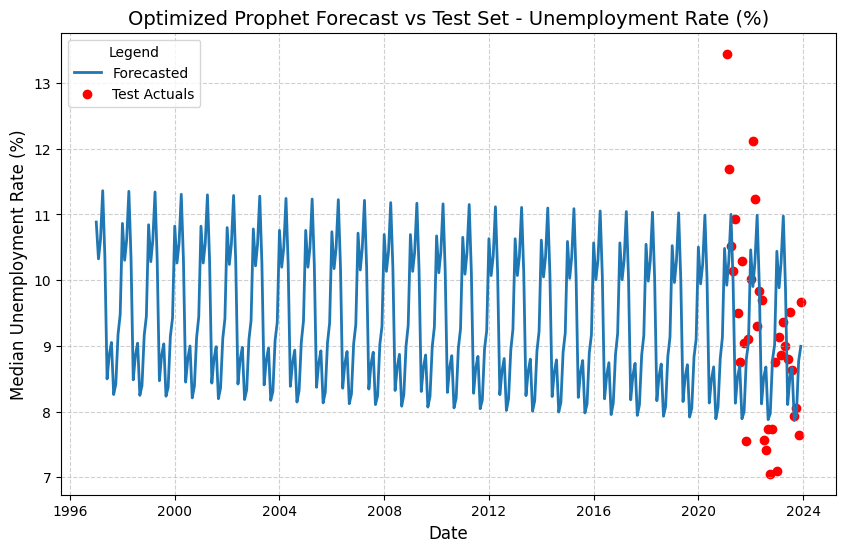

In [8]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted', linestyle='-', linewidth=2)
plt.scatter(evaluation.index, evaluation['y'], label='Test Actuals', color='red', marker='o')
plt.title("Optimized Prophet Forecast vs Test Set - Unemployment Rate (%)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Median Unemployment Rate (%)", fontsize=12)
plt.legend(title="Legend", fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.show()

In [13]:
# Generate plot
fig = plot_plotly(optimized_model, forecast)

# Add labels and title
fig.update_layout(
    title="Prophet Forecast - Unemployment Rate (%)",                 
    xaxis_title="Date",                       
    yaxis_title="Median Unemployment Rate (%)",        
    legend_title="Legend",                   
    font=dict(size=12),                       
)

# Show plot
fig.show()

In [10]:
# Generate plot
fig = plot_plotly(optimized_model, forecast)

# Add test data 
fig.add_trace(
    go.Scatter(
        x=test_data['ds'],  # x-axis (test data dates)
        y=test_data['y'],  # y-axis (actual values)
        mode='markers+lines',
        name='True Values (Test Data)',
        line=dict(color='red', dash='dot'),  
        marker=dict(color='red')
    )
)

# Adjust x-axis range (2021-2023)
fig.update_layout(
    xaxis=dict(
        range=['2021-01-01', '2023-12-31'],  # Set x-axis range
        title='Date',  # Add x-axis title
    ),
    yaxis=dict(
        title='Median Unemployment Rate (%)',  # Add y-axis title
    ),
    title='Prophet Forecast with Test Data (2021-2023) - Unemployment Rate (%)',  # Add plot title
)

# Show plot
fig.show()

In [11]:
# Generate plot
fig = plot_components_plotly(optimized_model, forecast)

# Add title and labels
fig.update_layout(
    title="Prophet Forecast - Unemployment Rate (%)",     
    font=dict(size=12),                      
)       

# Show plot
fig.show()